In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as disp
import seaborn as sns
from scipy import signal
from scipy.signal import lfilter
import scipy

sns.set_style('darkgrid')

Text(0.5, 1.0, 'The input frame EGG')

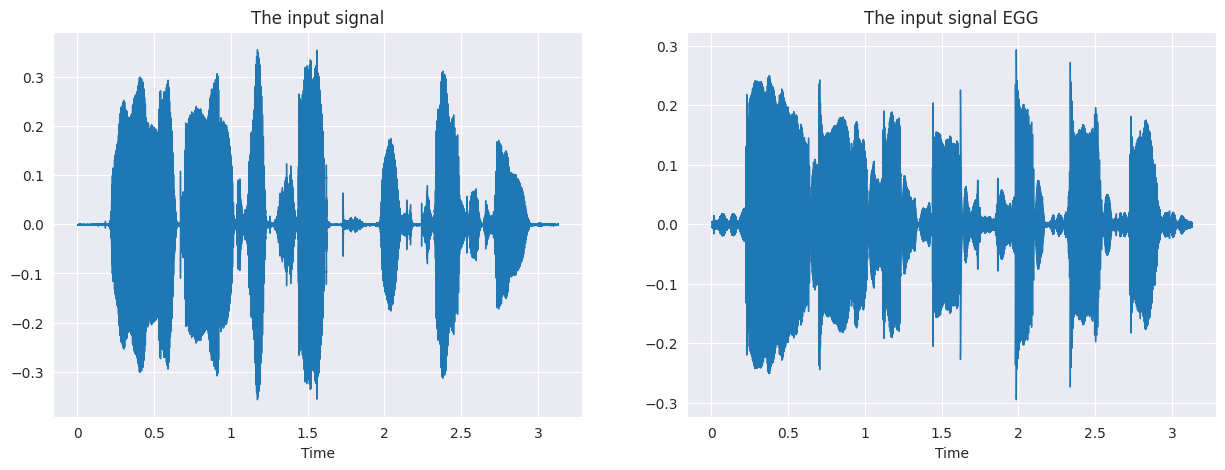

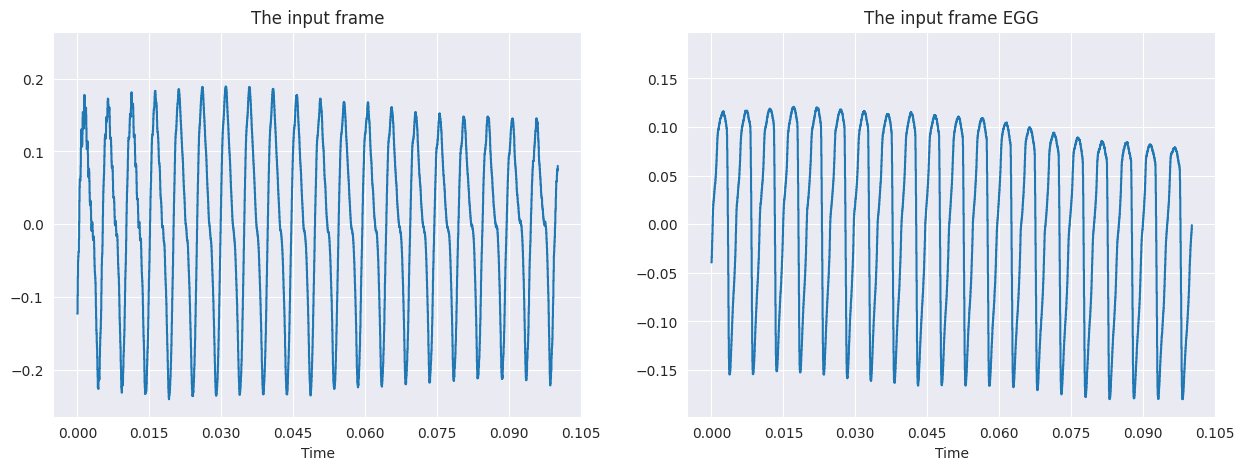

In [2]:
[sound,egg],fs = librosa.load('wav/arctic_b0539.wav',mono = False)

plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input signal")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input signal EGG" )

sound = sound[221*75:221*85]
egg = egg[221*75:221*85]

plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input frame")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input frame EGG" )



Text(608.3699494949494, 0.5, 'Amplitude')

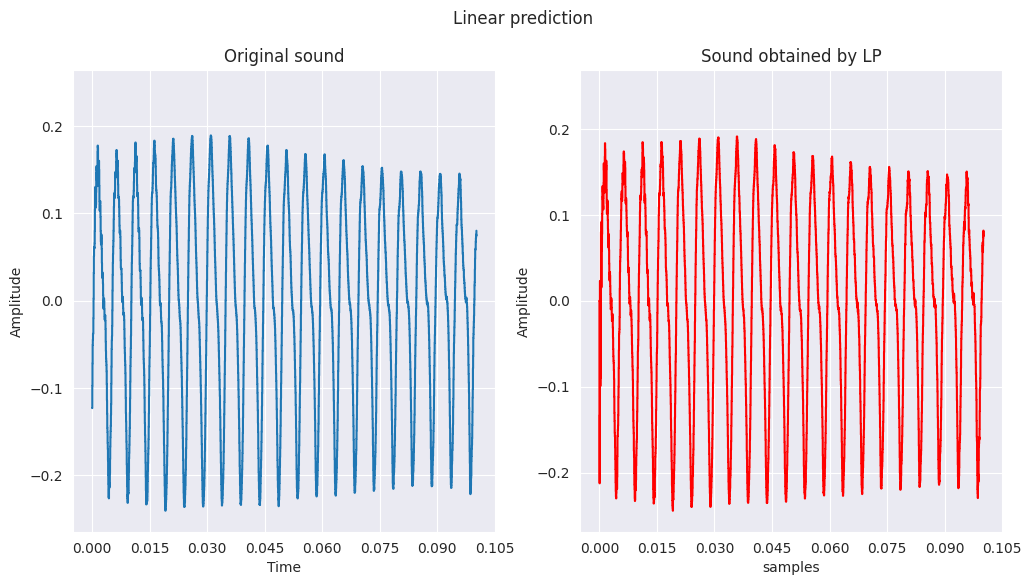

In [3]:
# LPC Spectrum 

lpc_coeff = librosa.lpc(sound, order=13)
lpc_coeff = -1 * np.array(lpc_coeff[1:])

arr = np.hstack([0, lpc_coeff])
sound_LP = scipy.signal.lfilter(arr, 1, sound)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.suptitle('Linear prediction')
disp.waveshow(sound)
plt.title('Original sound')
plt.ylabel("Amplitude")


plt.subplot(1,2,2)
disp.waveshow(sound_LP, color='red') 
plt.title("Sound obtained by LP")
plt.xlabel("samples")
plt.ylabel("Amplitude")

Text(83.59722222222221, 0.5, 'Amplitude')

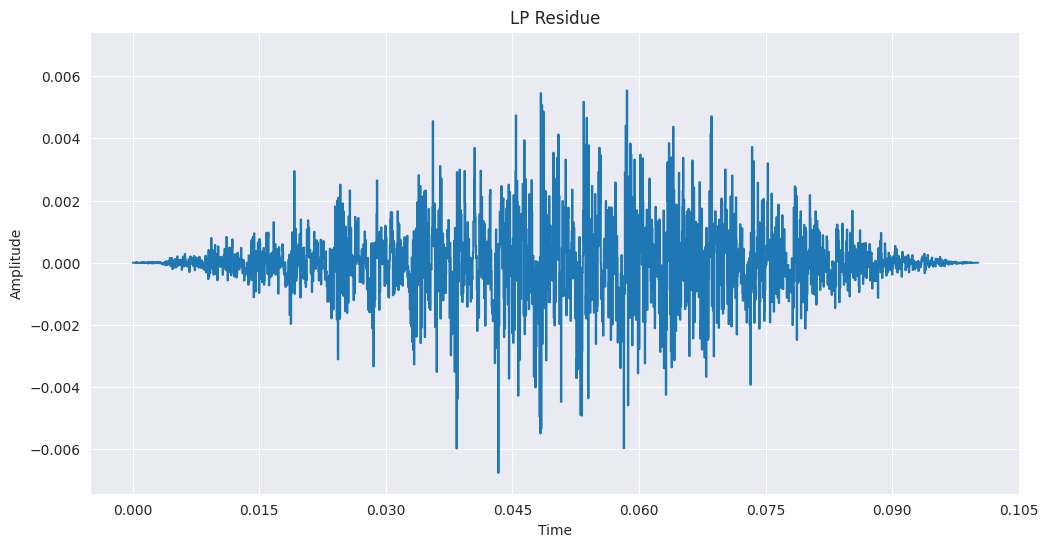

In [4]:
# LP Resiude

LP_residue = np.subtract(sound, sound_LP)   
plt.figure(figsize=(12,6))
# LP_residue = LP_residue[20:400]
LP_residue = LP_residue * scipy.signal.hann(len(LP_residue))
disp.waveshow(LP_residue)
plt.title('LP Residue')
plt.ylabel("Amplitude")





/home/user/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


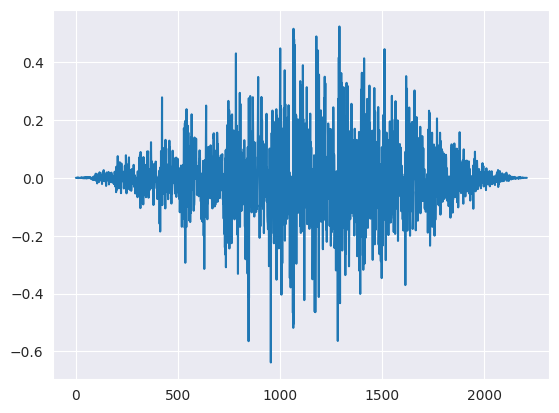

In [5]:
#calculate hilbert envelope of the LP residue
LP_residue_hilbert = scipy.signal.hilbert(LP_residue)
LP_residue_hilbert = LP_residue_hilbert/np.max(abs(LP_residue_hilbert))
plt.plot(LP_residue_hilbert)

In [6]:
#differncing the egg

egg1 = np.diff(egg)
egg_diff = np.diff(egg1)

/home/user/.local/lib/python3.8/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


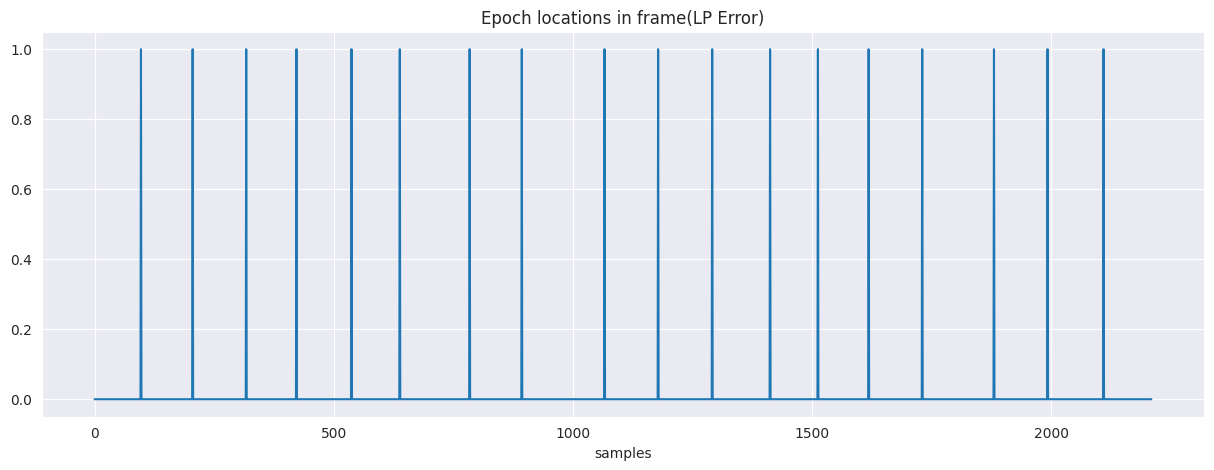

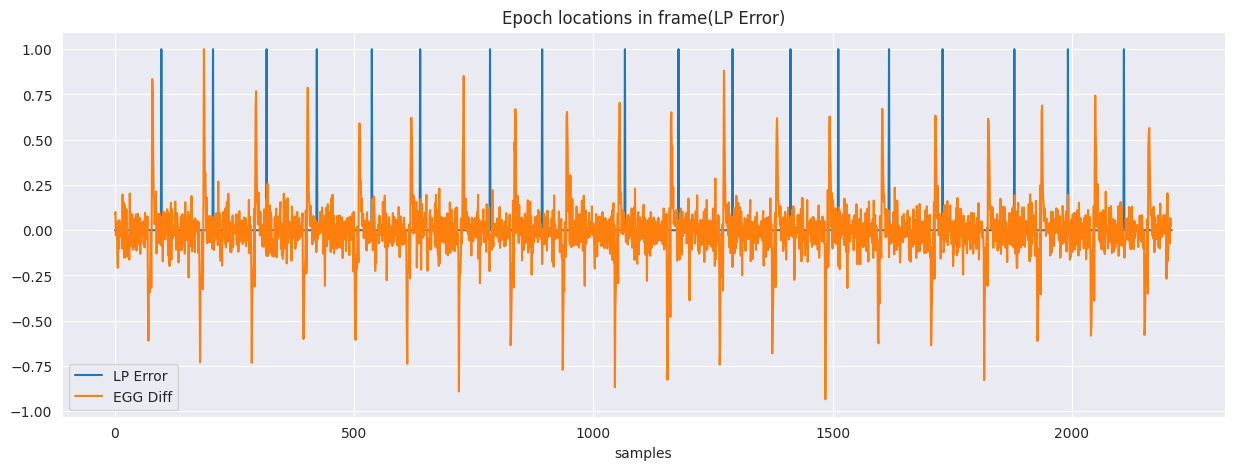

In [7]:
error_peaks,_ = scipy.signal.find_peaks(LP_residue_hilbert,height=0.0001,distance = 100)
epoch_LP = np.zeros(len(LP_residue))   

epoch_LP[error_peaks] = 1

plt.figure(figsize=(15,5))
plt.plot(epoch_LP)
plt.title("Epoch locations in frame(LP Error)")
plt.xlabel("samples")

plt.figure(figsize=(15,5))
plt.plot(epoch_LP)
plt.title("Epoch locations in frame(LP Error)")
plt.xlabel("samples")

egg_diff = egg_diff/np.max(abs(egg_diff))
plt.plot(egg_diff[:len(epoch_LP)])
plt.legend(["LP Error","EGG Diff"])

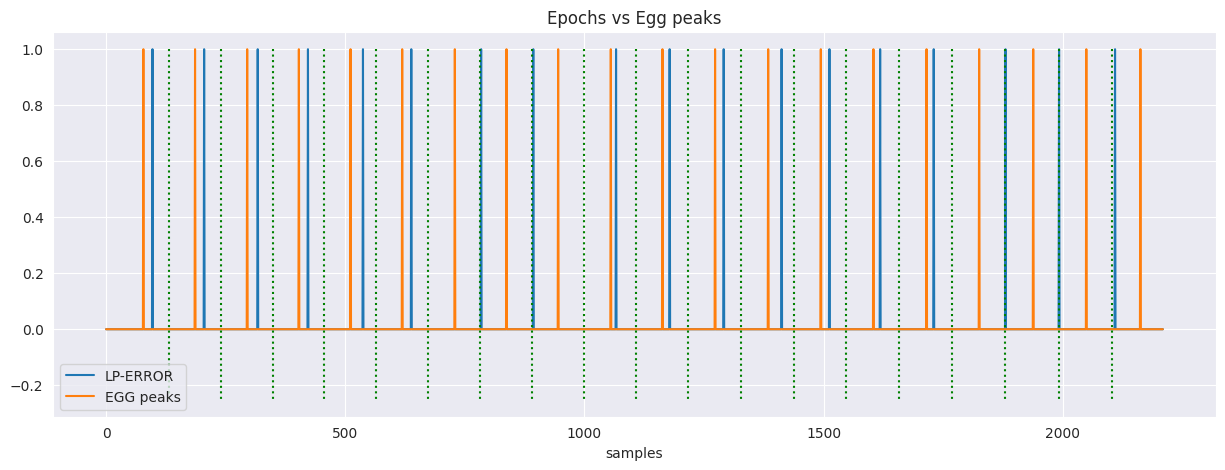

In [19]:
egg_diff[np.where(egg_diff < 0)] = 0
egg_peaks = np.zeros(len(epoch_LP))
peaks = scipy.signal.find_peaks(egg_diff[:len(epoch_LP)],height=0.5)

egg_peaks[peaks[0]] = 1

plt.figure(figsize=(15,5))
plt.plot(epoch_LP)
plt.plot(egg_peaks)
plt.xlabel("samples")
plt.title("Epochs vs Egg peaks")
plt.legend(["LP-ERROR","EGG peaks"])
# Adding long dotted vertical lines
for i in range(len(peaks[0])):
    current_peak = peaks[0][i]
    # Check if there is a subsequent epoch and it's at least 53.5 samples away
    if i < len(peaks[0]) - 1 and peaks[0][i + 1] - current_peak >= 53.5:
        plt.vlines(current_peak + 53.5, ymin=1, ymax=-0.25, colors='g', linestyles='dotted')


In [9]:
print(type(error_peaks))

print(type(peaks))

<class 'numpy.ndarray'>
<class 'tuple'>


In [18]:
print(peaks[0])

[  78  186  295  403  511  619  729  837  945 1055 1163 1273 1384 1494
 1604 1715 1825 1938 2049 2162]


In [10]:
print(epoch_LP[error_peaks[0]])
print(error_peaks[0])
print(peaks[0])
print(egg_peaks[peaks[0]])

1.0
97
[  78  186  189  295  403  511  619  729  835  837  945  952 1055 1163
 1165 1273 1384 1494 1604 1715 1825 1938 2049 2162]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
# Find top peaks in the differentiated EGG signal above 0.50 amplitude
threshold = 0.50
top_peaks, _ = scipy.signal.find_peaks(egg_diff, height=threshold)

# Plotting the differentiated EGG signal and marking the top peaks above 0.50 amplitude
# plt.figure(figsize=(15, 5))
# plt.plot(egg_diff, label='EGG Diff Signal')
# plt.plot(top_peaks, egg_diff[top_peaks], 'ro', label=f'Top Peaks (Amplitude > {threshold})')
# plt.legend()
# plt.title('EGG Diff Signal with Top Peaks above 0.50 Amplitude')
# plt.xlabel('Samples')
# plt.ylabel('Amplitude')
# plt.show()

# Find epochs in 'egg' signal
egg_epochs = []
for i in range(len(egg) - 1):
    if egg[i] * egg[i + 1] < 0 and egg[i + 1] > 0:
        egg_epochs.append(i)

# Comparing the number of epochs detected
num_sound_epochs = sum(epoch_LP)
num_egg_epochs = len(top_peaks)
print(f"Number of epochs detected in 'sound': {num_sound_epochs}")
print(f"Number of epochs detected in 'egg' signal: {num_egg_epochs}")


from tabulate import tabulate

# Calculate the distances between the individual epochs in milliseconds
sound_epochs = [i for i, value in enumerate(epoch_LP) if value == 1]

epoch_distances = []
for epoch_index in sound_epochs:
    closest_eggs = [abs(epoch_index - egg_index) for egg_index in top_peaks]
    epoch_distances.append(min(closest_eggs))

# Average distance between epochs
avg_epoch_distance = np.mean(epoch_distances)

# Identification errors (distance between detected epoch and closest ground truth GCI)
identification_errors = []
for epoch_index in sound_epochs:
    closest_index = min(top_peaks, key=lambda x: abs(epoch_index - x))
    identification_errors.append(abs(epoch_index - closest_index))

# Identification Accuracy (IDA = standard deviation of identification errors)
identification_accuracy = np.std(identification_errors)



# Convert sample indices to milliseconds
ms_per_sample = 1000 / fs  # Calculate the duration of a single sample in milliseconds

# Individual distances between epochs and EGG in milliseconds
epoch_distances_ms = [distance * ms_per_sample for distance in epoch_distances]

total_distance = 0
count = 0
table_data = []

# print("Individual distances between epochs and EGG in milliseconds:")
for idx, distance in enumerate(epoch_distances_ms):
    # print(f"Epoch {idx + 1} distance: {distance:.2f} ms")
    table_data.append([f"Epoch {idx + 1}", f"{distance:.2f} ms"])
    total_distance += distance - 0.3
    count += 1




# Average Identification Error
# avg_identification_error = np.mean(identification_errors)
avg_identification_error = total_distance / count

# Printing the table using tabulate
print(tabulate(table_data, headers=["Epoch", "Distance to EGG"], tablefmt="pretty"))

# print(f"Avg. distance between epochs and EGG in milliseconds: {avg_epoch_distance}")

print(f"\nAverage Identification Error: {avg_identification_error} ms")



Number of epochs detected in 'sound': 18.0
Number of epochs detected in 'egg' signal: 20
+----------+-----------------+
|  Epoch   | Distance to EGG |
+----------+-----------------+
| Epoch 1  |     0.86 ms     |
| Epoch 2  |     0.86 ms     |
| Epoch 3  |     1.00 ms     |
| Epoch 4  |     0.86 ms     |
| Epoch 5  |     1.18 ms     |
| Epoch 6  |     0.86 ms     |
| Epoch 7  |     2.40 ms     |
| Epoch 8  |     2.36 ms     |
| Epoch 9  |     0.50 ms     |
| Epoch 10 |     0.68 ms     |
| Epoch 11 |     0.82 ms     |
| Epoch 12 |     1.27 ms     |
| Epoch 13 |     0.82 ms     |
| Epoch 14 |     0.63 ms     |
| Epoch 15 |     0.68 ms     |
| Epoch 16 |     2.49 ms     |
| Epoch 17 |     2.45 ms     |
| Epoch 18 |     2.40 ms     |
+----------+-----------------+

Average Identification Error: 0.9849584278155707 ms


## hidden

In [11]:
# Calculate distances between each peak in 'peaks' and the closest peak in 'error_peaks'
distances = []
for peak in peaks[0]:
    closest_error_peak = error_peaks[np.argmin(np.abs(error_peaks - peak))]
    distance = np.abs(peak - closest_error_peak)
    distances.append(distance)

# Print distances
print("Distances between actual peaks and closest identified peaks:")
print(distances)

# Calculate and print the average distance
average_distance = np.mean(distances)
print("Average distance:", average_distance)


Distances between actual peaks and closest identified peaks:
[19, 19, 16, 22, 19, 26, 19, 55, 51, 53, 52, 59, 11, 15, 13, 18, 28, 18, 14, 15, 55, 54, 57, 53]
Average distance: 31.708333333333332


In [12]:

# Convert distances from samples to milliseconds
distances_ms = np.array(distances) / fs * 1000

# Print distances in milliseconds
print("Distances between actual peaks and closest identified peaks (in ms):")
print(distances_ms)

# Convert average distance to milliseconds
average_distance_ms = average_distance / fs * 1000
print("Average distance (in ms):", average_distance_ms)


Distances between actual peaks and closest identified peaks (in ms):
[0.861678   0.861678   0.72562358 0.99773243 0.861678   1.17913832
 0.861678   2.49433107 2.31292517 2.40362812 2.35827664 2.67573696
 0.49886621 0.68027211 0.58956916 0.81632653 1.26984127 0.81632653
 0.63492063 0.68027211 2.49433107 2.44897959 2.58503401 2.40362812]
Average distance (in ms): 1.4380196523053665
